In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import style
import random
from functions.stylizedfacts import *
import scipy.stats as stats
from functions.helpers import hurst, organise_data, div_by_hundred, discounted_value_cash_flow, find_horizon, calculate_npv
import matplotlib.pyplot as plt
import json
import math
from functions.find_bubbles import *
from functions.evolutionaryalgo import *
from SALib.sample import latin
import json

In [2]:
style.use('ggplot')

# Estimate model
Following the procedure presented by [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802).

The model should produce realistic booms-bust / deviations from the fundamentals as well as some standard no-autocorrelation moments associated with financial markets. 

Returns:
1. Average autocorrelation
2. Average absolute autocorrelation
3. Kurtosis

Bubbles:
4. percentage bubble occurence of total periods
5. average lenght of bubbles
6. standard deviation lenght of bubbles
7. skewness lenght of bubbles
8. kurtosis lenght of bubbles 


## 1 Get data

In [3]:
shiller_data = pd.read_excel('http://www.econ.yale.edu/~shiller/data/ie_data.xls', header=7)[:-3]

In [4]:
p = pd.Series(np.array(shiller_data.iloc[1174:-1]['Price'])) #starting in 1952  was 1224
y = pd.Series(np.array(shiller_data.iloc[1174:-1]['CAPE']))  

In [5]:
print (len(y), len(p))

601 601


### 1.a Bubbles in the data

In [14]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 299

In [15]:
bsadfs = PSY(y, swindow0, IC, adflag)

In [16]:
quantilesBsadf = cvPSYwmboot(y, swindow0, IC, adflag, Tb, nboot)

In [17]:
monitorDates = y.iloc[swindow0-1:obs].index
quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
ind95 =(bsadfs.T[0] > quantile95[1, ])
periods = monitorDates[ind95]

Rewrite find sequence in ints 

In [18]:
bubbly_dates = find_sequences_ints(periods, monitorDates)

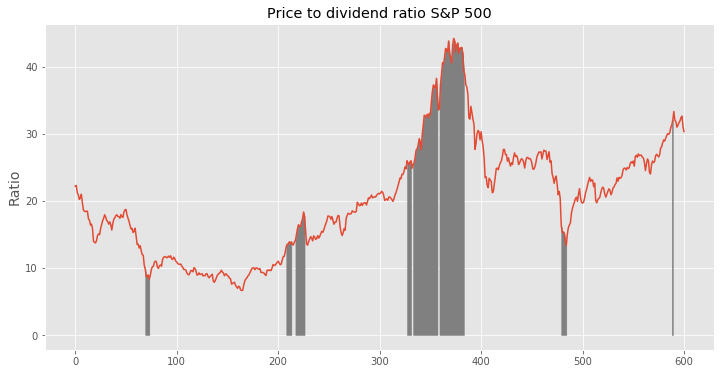

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,6))

ax1.plot(range(len(y)), y)

for loc in range(len(bubbly_dates)):
    bub_period = bubble_period(monitorDates , bubbly_dates.iloc[loc])
    ax1.fill_between(bub_period , y[bub_period], color='grey')
    
ax1.set_title('Price to dividend ratio S&P 500')
ax1.set_ylabel('Ratio', fontsize='14')

fig.savefig('sp500_bubbel.png')

#### Bubble moments

1. Percentage bubble occurence of total periods

In [13]:
# percentage bubble occurence 
percentage_bubbles = len(periods) / float(len(monitorDates))
percentage_bubbles

0.08876811594202899

2. Average lenght of bubbles

In [14]:
# av bubble lenght
lenghts_of_bubbles = []
for row in range(len(bubbly_dates)):
    lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)

In [15]:
av_lenght_bubbles = np.mean(lenghts_of_bubbles)
av_lenght_bubbles

6.125

3. Standard deviation lenght of bubbles

In [16]:
stdev_lenght_bubbles = np.std(lenghts_of_bubbles)
stdev_lenght_bubbles

5.3487732238336667

4. Skew lenght of bubbles

In [17]:
pd.Series(lenghts_of_bubbles).skew()

0.8304836435241798

5. Kurtosis lenght of bubbles

In [18]:
pd.Series(lenghts_of_bubbles).kurtosis()

-0.91551026215481279

In [20]:
p_returns = pd.Series(np.array(shiller_data.iloc[1174:]['Price'])).pct_change()[1:]
pd_returns = pd.Series(np.array(shiller_data.iloc[1174:]['CAPE'])).pct_change()[1:]

In [21]:
emp_moments = np.array([
    autocorrelation_returns(p_returns, 25),
    autocorrelation_abs_returns(p_returns, 25),
    kurtosis(p_returns),
    percentage_bubbles,
    av_lenght_bubbles,
    stdev_lenght_bubbles,
    pd.Series(lenghts_of_bubbles).skew(),
    pd.Series(lenghts_of_bubbles).kurtosis()
    ])

In [22]:
emp_moments

array([ 0.0094336 ,  0.05371445,  2.67297082,  0.08876812,  6.125     ,
        5.34877322,  0.83048364, -0.91551026])

## 2 Bootstrap data for both short and long-term moments

In [23]:
shiller_block_size = 75 # 8 blocks

To ensure continuity in the bootstrapped series, I block bootstrap the returns of the price to dividends ratio(not the ratio itself). Then, I multiply these returns with the starting values of the price to dividends ratio. This results in 5000 hypothetical time series of fundamentals and real prices. 

In [24]:
def hypothetical_series(starting_value, returns):
    """
    input: starting_value: float starting value
    input: returns: list 
    """
    returns = list(returns)
    simulated_series = [starting_value]
    for idx in range(len(returns)):
        simulated_series.append(simulated_series[-1] * (1 + returns[idx]))
    return simulated_series

In [25]:
# divide the pd returns into blocks
pd_data_blocks = []
p_data_blocks = []
for x in range(0, len(pd_returns[:-3]), shiller_block_size):
    pd_data_blocks.append(pd_returns[x:x+shiller_block_size])
    p_data_blocks.append(p_returns[x:x+shiller_block_size])

In [26]:
# draw 5000 random series 
bootstrapped_pd_series = []
bootstrapped_p_returns = []
for i in range(10):
    # bootstrap p returns
    sim_data_p = [random.choice(p_data_blocks) for _ in p_data_blocks]
    sim_data2_p = [j for i in sim_data_p for j in i]
    bootstrapped_p_returns.append(sim_data2_p)
    
    # first sample the data for pd returns
    sim_data = [random.choice(pd_data_blocks) for _ in pd_data_blocks] # choose a random set of blocks
    sim_data_fundamental_returns = [pair for pair in sim_data]
    
    # merge the list of lists
    sim_data_fundamental_returns1 = [item for sublist in sim_data_fundamental_returns for item in sublist]
    
    # calculate the new time_series
    sim_data_fundamentals = hypothetical_series(y[0], sim_data_fundamental_returns1[1:])
    bootstrapped_pd_series.append(sim_data_fundamentals) # used to also be price returns.. perhaps re-implement

## 3 Choose moments

For bubbles, I use the following moments: 
1. Percentage bubble occurence of total periods
2. Average lenght of bubbles
3. Standard deviation lenght of bubbles
4. Skew lenght of bubbles
5. Kurtosis lenght of bubbles

For returns, I use the following moments

6. mean first-order autocorrelation of the raw returns (no predictability),
7. mean first-order autocorrelation of the of the absolute returns (volatility clustering),
8. Kurtosis (fat tails), 

In [30]:
len(bsadfs)

551

In [32]:
perc_bubble_occur = []
av_lenghts_of_bubbles = []
stdev_lenghts_bubbles = []
skews_lenghts_bubbles = []
kurt_lengths_bubbles = []

for pds in bootstrapped_pd_series:
    # calc bubble stats
    pds = pd.Series(pds)
    
    obs = len(pds)
    dim = obs - swindow0 + 1
    
    bsadfs = PSY(pds, swindow0, IC, adflag)
    quantilesBsadf = cvPSYwmboot(pds, swindow0, IC, adflag, Tb, nboot)
    monitorDates = pds.iloc[swindow0-1:obs].index
    quantile95 = np.dot(np.array([quantilesBsadf]).T, np.ones([1, dim]))
    ind95 =(bsadfs.T[0] > quantile95[1, ])
    periods = monitorDates[ind95]
    
    bubbly_dates = find_sequences_ints(periods, monitorDates)
    
    perc_bubble_occur.append(len(periods) / float(len(monitorDates)))
    lenghts_of_bubbles = []
    for row in range(len(bubbly_dates)):
        lenghts_of_bubbles.append(bubbly_dates.iloc[row]['end_date'] - bubbly_dates.iloc[row]['start_date'] + 1)
    av_lenghts_of_bubbles.append(np.mean(lenghts_of_bubbles))
    stdev_lenghts_bubbles.append(np.std(lenghts_of_bubbles))
    skews_lenghts_bubbles.append(pd.Series(lenghts_of_bubbles).skew())
    kurt_lengths_bubbles.append((pd.Series(lenghts_of_bubbles).kurtosis()))

In [33]:
# replace NaN value of skew and kurtosis by zero (it is possible there were not enough bubbles to calc these so I assume a normal distribution)
skews_lenghts_bubbles = list(pd.Series(skews_lenghts_bubbles).fillna(0.0))#np.nanmedian(skews_lenghts_bubbles))) TODO decide
kurt_lengths_bubbles = list(pd.Series(kurt_lengths_bubbles).fillna(0.0))#np.nanmedian(kurt_lengths_bubbles)))

In [34]:
first_order_autocors = []
mean_abs_autocor = []
kurtoses = []
for rets in bootstrapped_p_returns:
    first_order_autocors.append(autocorrelation_returns(rets, 25))
    mean_abs_autocor.append(autocorrelation_abs_returns(rets, 25))
    rets = pd.Series(rets)
    kurtoses.append(kurtosis(rets))

In [35]:
all_bootstrapped_moments = [first_order_autocors,
                            mean_abs_autocor,
                            kurtoses,
                            perc_bubble_occur,
                            av_lenghts_of_bubbles,
                            stdev_lenghts_bubbles,
                            skews_lenghts_bubbles,
                            kurt_lengths_bubbles
                           ]

In [36]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [37]:
def get_specific_bootstraps_moments(full_series, bootstrap_number):
    """Get a vector with the moments of a specific bootstrap"""
    return np.array([full_series[i][bootstrap_number] for i in range(len(full_series))])

In [38]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(bootstrapped_pd_series))]

## 5 Estimate weighting matrix:

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

Then, I estimate the moment covariance matrix of the bootstrapped data as: 

$\hat{W} = \frac{1}{B} \sum{(m^b - \hat{m})(m^b - \hat{m})'}$

In [39]:
W_hat = 1.0 / len(bootstrapped_pd_series) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])

And take the inverse so that 

$W = \hat{W}^{-1}$

In [40]:
W = np.linalg.inv(W_hat)

In [41]:
# save weighting matrix
np.save('distr_weighting_matrix', W)

In [42]:
np.load('distr_weighting_matrix.npy')

array([[  8.31953409e+05,  -2.66329936e+05,   6.49887330e+03,
         -6.30903015e+04,  -3.44069850e+03,   5.59036593e+03,
          3.14638570e+03,  -4.20368901e+03],
       [ -2.66329936e+05,   1.00086061e+05,  -2.21706200e+03,
          1.92164306e+04,   1.03565999e+03,  -1.71259091e+03,
         -1.26058448e+03,   1.36795330e+03],
       [  6.49887330e+03,  -2.21706200e+03,   5.70711894e+01,
         -5.13564927e+02,  -2.71162854e+01,   4.37974180e+01,
          2.40243674e+01,  -3.30590738e+01],
       [ -6.30903015e+04,   1.92164306e+04,  -5.13564927e+02,
          5.96443543e+03,   2.61685687e+02,  -4.35986771e+02,
         -2.38123874e+02,   3.19612151e+02],
       [ -3.44069850e+03,   1.03565999e+03,  -2.71162854e+01,
          2.61685687e+02,   1.65411564e+01,  -2.52776150e+01,
         -1.17346427e+01,   1.84525173e+01],
       [  5.59036593e+03,  -1.71259091e+03,   4.37974180e+01,
         -4.35986771e+02,  -2.52776150e+01,   3.97455510e+01,
          2.00357580e+01,  -2.9

In [43]:
emp_moments

array([ 0.0094336 ,  0.05371445,  2.67297082,  0.08876812,  6.125     ,
        5.34877322,  0.83048364, -0.91551026])

In [44]:
confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [45]:
confidence_intervals

[(-0.022202026015152289, 0.041069220592631774),
 (0.022108192370337107, 0.085320714884367599),
 (1.0723358902783118, 4.273605757608955),
 (-0.076754912345883441, 0.25429114422994142),
 (-5.155370693731264, 17.405370693731264),
 (-8.0150125500091036, 18.712558997676439),
 (-1.3580170035694392, 3.0189842906177988),
 (-10.886295219267641, 9.0552746949580154)]

In [46]:
# export conrfidence intervals of bootstrapped data
with open('distr_bootstrapped_confidence_intervals.json', 'w') as fp:
    json.dump(confidence_intervals, fp)

Then, I apply the cost function to the bootstrapped series to get a distribution of J-values

In [47]:
j_values = []
for b in moments_b:
    j_values.append(quadratic_loss_function(b, emp_moments, W))

In [48]:
# export J-values of bootstrapped data
with open('distr_bootstrapped_j_values.json', 'w') as fp:
    json.dump(j_values, fp)

Futhermore, I calculate the MCR for the bootstrapped moments as follows:

10

In [66]:
scores = [0 for x in moments_b[0]]
scores

[0, 0, 0, 0, 0, 0, 0, 0]

In [67]:
for bootstr in range(len(moments_b)):
    for idx, moment in enumerate(moments_b[bootstr]):
        if moment > confidence_intervals[idx][0] and moment < confidence_intervals[idx][1]:
            scores[idx] += 1

In [77]:
MCR_bootstrapped_moments = np.array(scores) / (np.ones(len(scores)) * len(moments_b))

## 6 Estimate model

To estimate the model parameters, I employ the traditional approach for the method of simulated moments by minimizing the quadtratic loss function: 

$J = J(m) = (m^{sim} - m^{emp})' W (m^{sim} - m^{emp}) $

The first term is the transpose of the difference between simulated and actual moments. The seond term is the weighting matrix. The third term is the difference between simulated and empirical moments. 


To reduce the sample variability in the stochastic simulations, I choose a time horizon (following [Franke & Westerhoff (2012)](https://www.sciencedirect.com/science/article/pii/S0165188912000802)) of 10 times the empirical time series. In this case the longest time series. 

## Export latin-hypercube

In [49]:
population_size = 10

In [50]:
problem = {
  'num_vars': 7,
  'names': ['std_noise',
            'w_fundamentalists', 'w_momentum',
            'base_risk_aversion',
            "fundamentalist_horizon_multiplier",
            "mutation_probability",
            "average_learning_ability"],
  'bounds': [[0.05, 0.30],
             [0.0, 100.0], [0.0, 100.0],
             [0.1, 15.0],
             [0.1, 1.0], [0.1, 0.9],
             [0.1, 1.0]]
}

In [51]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

In [52]:
with open('hypercube.txt', 'w') as f:
    json.dump(latin_hyper_cube, f)